## Convolutional Neural Networks

## Project: Algorithm for a Dog Identification App 

### Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('/data/dog_images/train')
valid_files, valid_targets = load_dataset('/data/dog_images/valid')
test_files, test_targets = load_dataset('/data/dog_images/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("/data/dog_images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))



Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("/data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))


There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


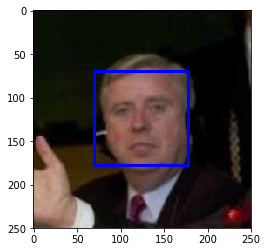

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[10001])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

### Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assessment the Human Face Detector

- Human face detected as human face : 100 % 
- Dog image detected as human face : 11 % 

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

## Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

performance_human = np.sum([face_detector(human_file)*1 for human_file in human_files_short])
performance_dog   = np.sum([face_detector(dog_file)*1 for dog_file in dog_files_short])

print('Human face detected as human face : %d %% ' % performance_human)
print('Dog image detected as human face : %d %% ' % performance_dog)

Human face detected as human face : 100 % 
Dog image detected as human face : 11 % 


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [7]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 3s 0us/step


### Pre-process the Data



In [8]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50


In [9]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Dog Detector


In [10]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

###  Assessment the Dog Detector

- Human face detected as dog image : 0 % 
- Dog image detected as dog image : 100 % 

In [11]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

performance_dog_human = np.sum([dog_detector(human_file)*1 for human_file in human_files_short])
performance_dog_dog   = np.sum([dog_detector(dog_file)*1 for dog_file in dog_files_short])

print('Human face detected as dog image : %d %% ' % performance_dog_human)
print('Dog image detected as dog image : %d %% ' % performance_dog_dog)

Human face detected as dog image : 0 % 
Dog image detected as dog image : 100 % 


---
<a id='step3'></a>
## Step 3: CNN to Classify Dog Breeds

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  


### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [12]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:08<00:00, 100.17it/s]


###  Model Architecture

The architecture proposed here is the same as the one studied in the tutorial as we are dealing with the same kind of data consisting in a set of colored pictures that we want to classify.

Pictures of different breeds of dogs are applied to the input layer of the CNN as a full RGB 224x224 pixel images. The basic idea in performing a good classification is to reveal the various features that make the difference between diverse breeds at each level of the CNN. The first layer is composed of 16 filters that are generally responsible for detecting the edges and colors variation. The second layer uses the data coming from the previous one uses 32 filters to detect more complex forms such as circles, lines, rectangles, ... The third layer takes the output of the previous one to reveal features related to each breed such as the form of the ears, the eyes, the proportion of the legs regarding the body, and so on. The last layer is a fully connected layer. It provides the probability of each breed. The convolutional layers are separated by max pooling layers for data compression. So the basic idea is to move from a picture that contains tons of spatial information to a set of features that allow to differentiate the subtilities between breeds.

In [13]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(GlobalAveragePooling2D())

model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

### Compile the Model

In [14]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model



In [15]:
from keras.callbacks import ModelCheckpoint  

epochs = 5

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/5
6680/6680 [==============================] - 21s 3ms/step - loss: 4.8839 - acc: 0.0088 - val_loss: 4.8677 - val_acc: 0.0096
Epoch 2/5
6680/6680 [==============================] - 21s 3ms/step - loss: 4.8555 - acc: 0.0100 - val_loss: 4.8461 - val_acc: 0.0156
Epoch 3/5
6680/6680 [==============================] - 21s 3ms/step - loss: 4.8139 - acc: 0.0145 - val_loss: 4.8089 - val_acc: 0.0216
Epoch 4/5
6680/6680 [==============================] - 21s 3ms/step - loss: 4.7804 - acc: 0.0190 - val_loss: 4.7876 - val_acc: 0.0251
Epoch 5/5
6680/6680 [==============================] - 21s 3ms/step - loss: 4.7530 - acc: 0.0193 - val_loss: 4.7759 - val_acc: 0.0192


### Load the Model with the Best Validation Loss

In [16]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model


In [17]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 3.2297%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds


### Obtain Bottleneck Features

In [18]:
bottleneck_features = np.load('/data/bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [19]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [20]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [21]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 312us/step - loss: 11.9248 - acc: 0.1352 - val_loss: 10.2418 - val_acc: 0.2359
Epoch 2/20
6680/6680 [==============================] - 2s 255us/step - loss: 9.4900 - acc: 0.2975 - val_loss: 9.3821 - val_acc: 0.3054
Epoch 3/20
6680/6680 [==============================] - 2s 253us/step - loss: 8.8779 - acc: 0.3732 - val_loss: 9.2340 - val_acc: 0.3353
Epoch 4/20
6680/6680 [==============================] - 2s 252us/step - loss: 8.6219 - acc: 0.4084 - val_loss: 9.0889 - val_acc: 0.3581
Epoch 5/20
6680/6680 [==============================] - 2s 252us/step - loss: 8.4234 - acc: 0.4334 - val_loss: 8.9361 - val_acc: 0.3653
Epoch 6/20
6680/6680 [==============================] - 2s 252us/step - loss: 8.1803 - acc: 0.4572 - val_loss: 8.7226 - val_acc: 0.3677
Epoch 7/20
6680/6680 [==============================] - 2s 252us/step - loss: 8.0312 - acc: 0.4729 - val_loss: 8.6447 - val_acc: 0.3784

### Load the Model with the Best Validation Loss

In [22]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model


In [23]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 44.0191%


### Predict Dog Breed with the Model

In [24]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)


### Obtain Bottleneck Features


In [25]:
### Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('/data/bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

###  Model Architecture

The aim is to use transfer learning to avoid consuming time and ressource while training a CNN from scratch. From the list of the pre-trained networks I chose the Resnet50 architecture. Restnet50 is used here as a fixed feature extractor serving as input to our model. I add an average pooling layer along with a fully connected layer with a softmax to calculate the probability of each breed.

The steps are outlined as follows: after compling the model, I train it using the training and validation sets. The training takes far less time than the CNN I created in step 3 as the weights of the pre-trained CNN are maintained. I then load the model parameters that give the best validation loss and test the model on the test set. 

The accuracy obtained is around 80% which is far above the 3.22% accuracy obtained with our CNN in step 3. Therefore, transfer learning proves its efficiency in both processing time and accuracy improvment.


In [26]:
### Architecture.
Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(133, activation='softmax'))

Resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [27]:
### Compile the model.
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model
 

In [28]:
### Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 264us/step - loss: 1.6408 - acc: 0.5907 - val_loss: 0.8385 - val_acc: 0.7449
Epoch 2/20
6680/6680 [==============================] - 1s 220us/step - loss: 0.4435 - acc: 0.8569 - val_loss: 0.6940 - val_acc: 0.7928
Epoch 3/20
6680/6680 [==============================] - 1s 219us/step - loss: 0.2689 - acc: 0.9130 - val_loss: 0.6946 - val_acc: 0.8024
Epoch 4/20
6680/6680 [==============================] - 1s 220us/step - loss: 0.1747 - acc: 0.9439 - val_loss: 0.6375 - val_acc: 0.8048
Epoch 5/20
6680/6680 [==============================] - 1s 218us/step - loss: 0.1175 - acc: 0.9656 - val_loss: 0.7034 - val_acc: 0.8144
Epoch 6/20
6680/6680 [==============================] - 1s 218us/step - loss: 0.0898 - acc: 0.9735 - val_loss: 0.7110 - val_acc: 0.8120
Epoch 7/20
6680/6680 [==============================] - 1s 219us/step - loss: 0.0652 - acc: 0.9804 - val_loss: 0.6636 - val_acc: 0.8359
E

###  Load the Model with the Best Validation Loss

In [29]:
### Load the model weights with the best validation loss.
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

### Test the Model


In [30]:
### Calculate classification accuracy on the test dataset.

# get index of predicted dog breed for each image in test set
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 80.9809%


###  Predict Dog Breed with the Model


In [31]:
### function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

from extract_bottleneck_features import *

def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Final Algorithm


Image path: /data/dog_images/train/006.American_eskimo_dog/American_eskimo_dog_00398.jpg
Hello, dog!


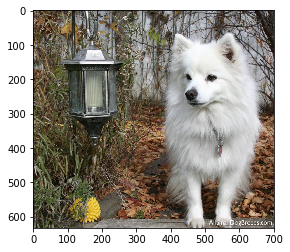

You look like a ...
94658560/94653016 [==============================] - 2s 0us/step
in/006.American_eskimo_dog


In [32]:
#if a dog is detected in the image, return the predicted breed.
#img_path = human_files[28]
img_path = train_files[54]
#img_path = 'myimages/hasnae.jpg'
print('Image path:', img_path)

img = cv2.imread(img_path)
if dog_detector(img_path):
    print('Hello, dog!')
elif face_detector(img_path):
    print('Hello, human!')
else:
    print('Hello, not human, not dog!')
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

print('You look like a ...')
print(Resnet50_predict_breed(img_path))

---
<a id='step7'></a>
## Step 7: Test of the Algorithm

The algorithm has been tested on 6 differents images :
- Two images of dogs: one in an iconic format and another with other objects in the picture (dog playing with a rope)
- Two images of humans: a women and a group of friends
- One image that do not contain humans nor dogs: a cat.
- One image showing a man and a dog. 

After the processing, my comments on the results are as follows:
- The dog was correctly identified. Beagle breed is good one
- The dog playing with the rope was correctly detected but was misidentified. Dogue de Bordeaux is not the correct breed for the animal in the image
- The woman was correctly detected. The ressemblence with the alaskan malamute seems acceptable
- The image showing the group of friends was correctly labled as human, but we don't know for sure which one has a similarity with the indicated breed
- The fifth image that displays a man with a dog is confusing. The algorithm gave priority to the dog label as this is what was programmed in the function image_type. However, the algorithm failed to reveal the correct breed of the dog. Clearly, the dog is not a bloodhound.
- The last image of the cat was correctly labled as unrecognized

From what preceeds, I can suggest the three following improvments to the algorithm:
- In case there is a human an a dog, indicate that both a human and a dog is detected and that the shown breed corresponds to the dog
- In case many humans are detected, show this information and give the ressemblence of only one of them (the one to the left), or display a list of ressemblences starting from the upper left to the bottom right
- It would be interesting to display the probability of the calculated breed and in case two or more breeds have close probabilities, display both or all of them


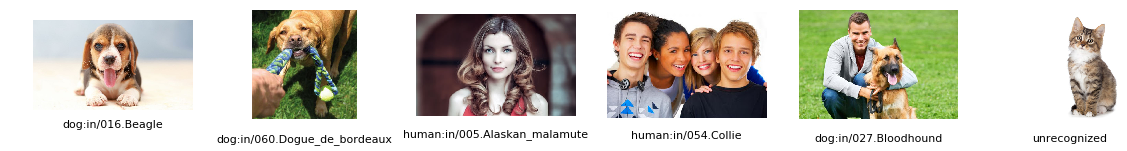

In [36]:
def image_type(img_path):
    #detect image type
    if dog_detector(img_path):
        img_type = 'dog'
    elif face_detector(img_path):
        img_type = 'human'
    else:
        img_type = 'unrecognized'
    #detect dog breed
    if img_type == 'unrecognized':
        return (img_type)
    else:
        return(img_type+':'+Resnet50_predict_breed(img_path))
    
#myimages = np.array(['hasnae.jpg', 'karim.jpg', 'karim2.jpg', 'nour.jpg', 'iyad.jpg', 'majd.jpg'])
myimages = np.array(['dog1.jpg', 'dog3.jpg', 'woman.jpg', 'friends.jpg',  'dog_man.jpg', 'cat.jpg'])
img_nb = 6
fig = plt.figure(figsize=(20,2))

for i in range(0, img_nb):
    ax = fig.add_subplot(1, img_nb, i+1)
    img_path = 'test_images/' + myimages[i]
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(cv_rgb)
    ax.axis('off')
    ax.text(0.5,-0.2, image_type(img_path), size=11, ha="center", transform=ax.transAxes)

#fig.suptitle('Images', fontsize=20)
plt.show()